b:  DiscreteVariable(probability=[0.1 0.9])
f:  DiscreteVariable(probability=[0.1 0.9])
g:  DiscreteVariable(probability=[0.315 0.685])
b:  DiscreteVariable(probability=[0.25714286 0.74285714])
f:  DiscreteVariable(probability=[0.25714286 0.74285714])
g:  DiscreteVariable(observed=[1. 0.])
b:  DiscreteVariable(observed=[1. 0.])
f:  DiscreteVariable(probability=[0.11111111 0.88888889])
g:  DiscreteVariable(observed=[1. 0.])


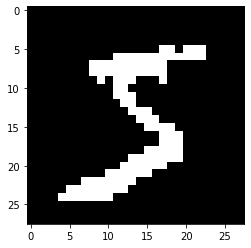

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from prml.bayesnet.discrete import discrete, DiscreteVariable
from neural_network.mnist import load_mnist

np.random.seed(1234)

b = discrete([0.1, 0.9])  # p(b=1)=0.1, p(b=2)=0.9
f = discrete([0.1, 0.9])  # p(f=1)=0.1, p(f=2)=0.9

g = discrete([
    [[0.9, 0.8], [0.8, 0.2]], # p(g=1,b=1,f=1)=0.9, p(g=1,b=1,f=2)=0.8, p(g=1,b=2,f=1)=0.8, p(g=1,b=2,f=2)=0.2
    [[0.1, 0.2], [0.2, 0.8]]  # p(g=2,b=1,f=1)=0.1, p(g=2,b=1,f=2)=0.2, p(g=2,b=2,f=1)=0.2, p(g=2,b=2,f=2)=0.8
], b, f)  # p(g|b,f)

print("b: ", b)
print("f: ", f)
print("g: ", g)

g.observe(0)

print("b: ", b)
print("f: ", f)
print("g: ", g)

b.observe(0)

print("b: ", b)
print("f: ", f)
print("g: ", g)

(train_x, _), (_, _) = load_mnist(normalize=False)
x = train_x[0]
img = (x > 127).astype(np.int).reshape(28, 28)
# plt.imshow(img, cmap="gray")

indices = np.random.choice(img.size, size=int(img.size * 0.1), replace=False)
noisy_img = np.copy(img)
noisy_img.ravel()[indices] = 1 - noisy_img.ravel()[indices]
plt.imshow(noisy_img, cmap="gray")


マルコフ確率場を使って、このノイズ画像を復元

In [ ]:

markov_random_field = np.array([
    [[discrete([0.5, 0.5], name=f"p(z_({i},{j}))") for j in range(28)] for i in range(28)],
    [[DiscreteVariable(2) for _ in range(28)] for _ in range(28)]
])

a = 0.9
b = 0.9
pa = [[a, 1-a], [1-a, a]]
pb = [[b, 1-b], [1-b, b]]

for i, j in itertools.product(range(28), range(28)):
    discrete(pb, markov_random_field[0, i, j], out=markov_random_field[1,i,j],name=f"p(x_({i},{j})|z_({i},{j}))")
    if i != 27:
        discrete(pa, out=[markov_random_field[0,i,j],markov_random_field[0,i+1,j]],name=f"p(z_({i},{j}), z_({i+1},{j}))")
    if j != 27:    
        discrete(pa, out=[markov_random_field[0,i,j],markov_random_field[0,i,j+1]],name=f"p(z_({i},{j}), z_({i},{j+1}))")
    markov_random_field[1, i, j].observe(noisy_img[i, j], prop_range=0)
        

for _ in range(1000):
    i, j = np.random.choice(28, 2)
    markov_random_field[1, i, j].send_message(prop_range=3)
restored_img = np.zeros_like(noisy_img)
for i, j in itertools.product(range(28), range(28)):
    restored_img[i, j] = np.argmax(markov_random_field[0, i, j].probability)
plt.imshow(restored_img, cmap="gray")    
        

